In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from scripts.imagedata import ImageData
from scripts.neutralliner import NeutralLiner
from scripts.config import device
from scripts.helper import prepare_gpr_results
IMG_SIZE = (50, 100)

#### Here i use first 100 'good' samples from GP model

## Load data

In [2]:
samples = torch.load('accepted_samples.pt')
samples = samples[:100]

### Plot signs

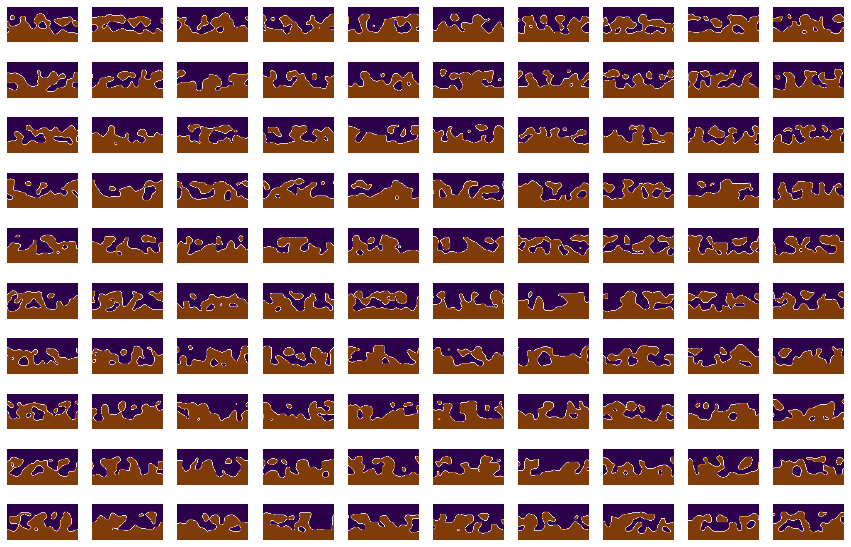

In [3]:
plt.figure(figsize=(15, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(samples[i] > 0, cmap='PuOr')
    # plt.title(i + 1)
    plt.axis('off')


### Plot splitted

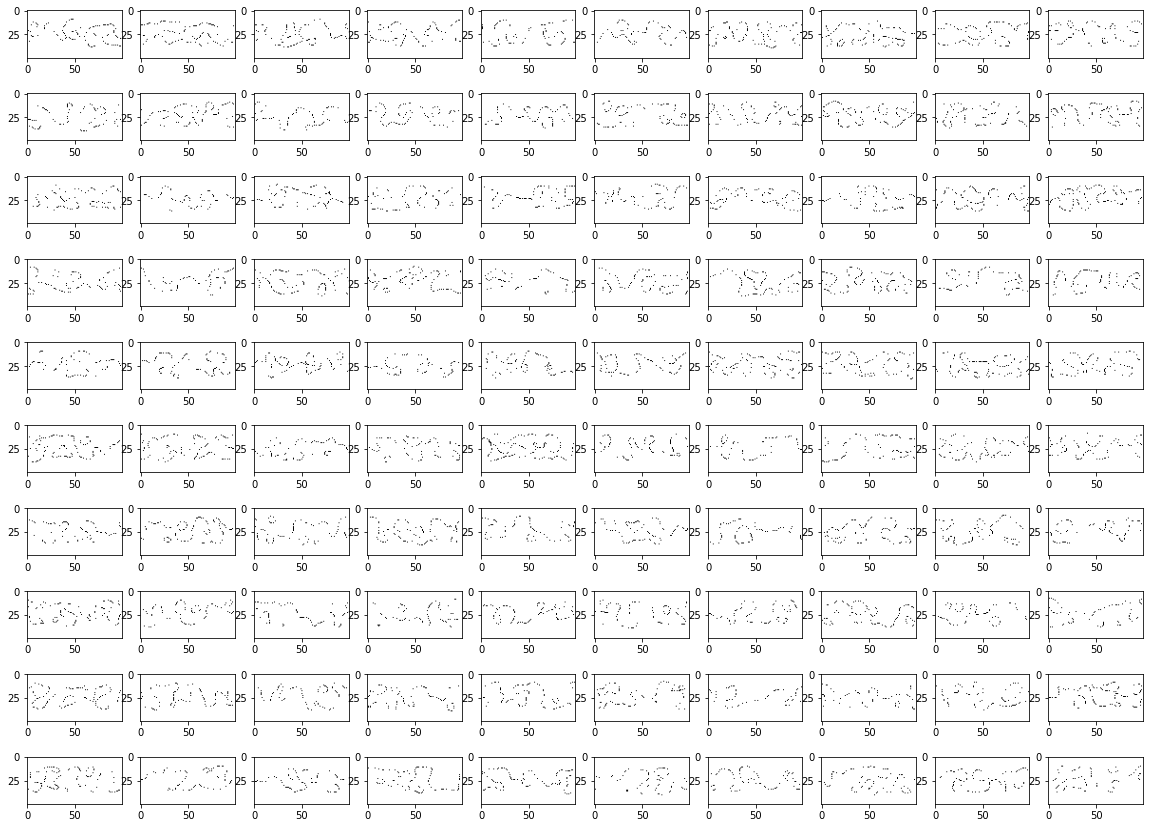

In [7]:
plt.figure(figsize=(20, 15))
for i in range(100):
    *_, splitted = prepare_gpr_results(samples[i], 0.65, need_plot=False)
    plt.subplot(10, 10, i + 1)
    plt.imshow(splitted, cmap='gray')

# FINAL TEST

In [21]:
def test_me(samples, stage, p):
    path = os.path.join('./Tests/CloC1', stage)
    os.makedirs(path, exist_ok=True)
    with open(os.path.join(path, 'res.txt'), 'w') as f:
        for i, sample in enumerate(tqdm(samples, desc='samples')):
            # make a directory for every sample
            cur_dir = os.path.join(path, str(i + 1))
            os.mkdir(cur_dir)
            _, sign, splitted = prepare_gpr_results(img=sample, p=p, need_plot=False)
            f.write(f'sample {i+1}:\n')
            for k in range(5):
                dataset = ImageData(path_or_img=splitted, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
                dataset_list = [dataset]
                model = NeutralLiner(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
                model.to(device)
                model.start_training(num_epochs=15e+3, my_weight=0.1, need_save=False, need_plot=False)
                predictions = model.test_model(need_plot=False)
                prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
                a = (prediction > 0).float()
                mae = float(((sign.float() - a).abs()).mean())
                # plot and save the result without plot
                plt.figure(figsize=(20, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(sign, cmap='PuOr')
                plt.title('Original')
                plt.subplot(1, 3, 2)
                plt.imshow(splitted, cmap='gray')
                plt.title('Splitted')
                plt.subplot(1, 3, 3)
                plt.imshow(prediction > 0, cmap='PuOr')
                plt.title('Prediction {}\nError: {:.2f}'.format(k + 1, mae))
                plt.savefig(os.path.join(cur_dir, f'result_{k + 1}.png'), facecolor='white')
                plt.close()
                plt.clf()
                model.save_state_dict(os.path.join(cur_dir, f'model_{k + 1}.pth'))
                f.write(f'Error_{k + 1}: {mae:.2f}\n')
            f.write('\n')

In [22]:
samples = torch.load('./Tests/CloC1/samples.pt')

## Full boundary

In [8]:
test_me(stage='0B', p=0, samples=samples)

samples: 100%|██████████| 100/100 [10:06:26<00:00, 363.87s/it]


<Figure size 432x288 with 0 Axes>

## Erase 50% if boundary

In [9]:
test_me(stage='50B', p=0.5, samples=samples)

## Erase 65% of boundary

In [11]:
test_me(stage='65B', p=0.65, samples=samples)

## Erase 80% of boundary

In [15]:
test_me(stage='80B', p=0.8, samples=samples)

## Erase 90% of boundary

In [ ]:
test_me(stage='90B', p=0.9, samples=samples)

## Erase 95% of boundary

In [ ]:
test_me(stage='95B', p=0.95, samples=samples)

# Averaging

## Different ways of averaging

Text(0.5, 1.0, 'Original')

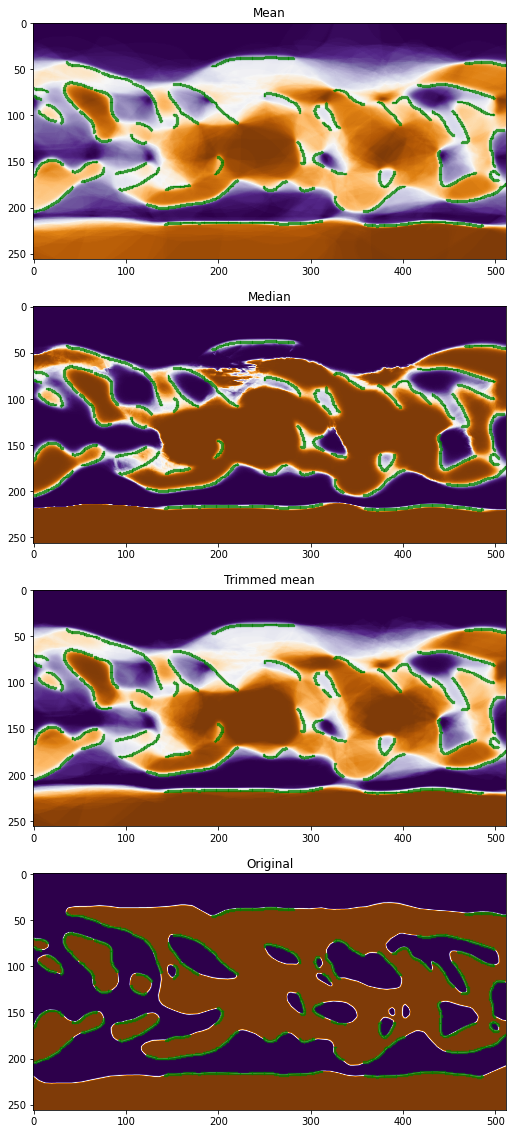

In [67]:
imgdata = ImageData(path_or_img='./imgs/fits/McIntosh/ptmc_compo_sm_19561227_013841_cr1382k_l3.fits', data_mode='fits')
x, y = np.where(imgdata.img_array < imgdata.img_array.max())
model = NeutralLiner(image_list=[imgdata], lr=5e-3, weight_decay=1e-4)
model.to(device)
weights = os.listdir('./state_dict/fits/averaging/19561227')
predictions = []
for weight in weights:
    model.load_state_dict(torch.load(os.path.join('./state_dict/fits/averaging/19561227', weight)))
    pred = model.test_model(need_plot=False)[0].view(imgdata.img_array.shape).cpu().detach()
    predictions.append(pred)
predictions = torch.stack(predictions)
predictions = predictions.numpy()
from scipy import stats

mean_img = predictions.mean(axis=0)
median_img = np.median(predictions, axis=0)
trimmed_mean_img = stats.trim_mean(predictions, proportiontocut=0.1, axis=0)
n=4
plt.figure(figsize=(10, 20))
plt.subplot(n, 1, 1)
plt.imshow(mean_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Mean')
plt.subplot(n, 1, 2)
plt.imshow(median_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Median')
plt.subplot(n, 1, 3)
plt.imshow(trimmed_mean_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Trimmed mean')
plt.subplot(n, 1, 4)
plt.imshow(imgdata.target_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Original')


Text(0.5, 1.0, 'Original')

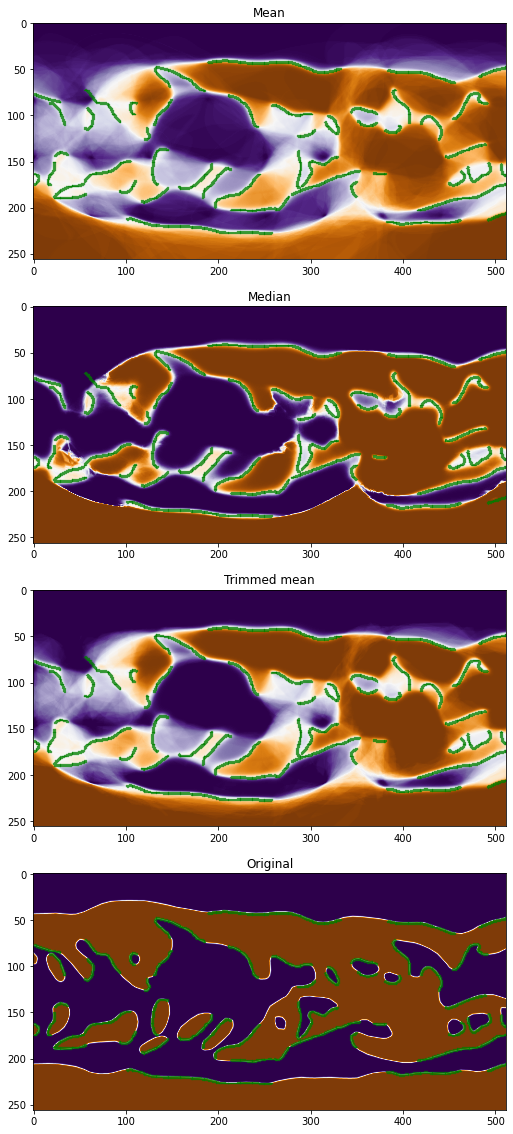

In [66]:
imgdata = ImageData(path_or_img='./imgs/fits/McIntosh/ptmc_compo_sm_19561102_102641_cr1380k_l3.fits', data_mode='fits')
x, y = np.where(imgdata.img_array < imgdata.img_array.max())
model = NeutralLiner(image_list=[imgdata], lr=5e-3, weight_decay=1e-4)
model.to(device)
weights = os.listdir('./state_dict/fits/averaging/19561102')
predictions = []
for weight in weights:
    model.load_state_dict(torch.load(os.path.join('./state_dict/fits/averaging/19561102', weight)))
    pred = model.test_model(need_plot=False)[0].view(imgdata.img_array.shape).cpu().detach()
    predictions.append(pred)
predictions = torch.stack(predictions)
predictions = predictions.numpy()
from scipy import stats

mean_img = predictions.mean(axis=0)
median_img = np.median(predictions, axis=0)
trimmed_mean_img = stats.trim_mean(predictions, proportiontocut=0.1, axis=0)
n=4
plt.figure(figsize=(10, 20))
plt.subplot(n, 1, 1)
plt.imshow(mean_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Mean')
plt.subplot(n, 1, 2)
plt.imshow(median_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Median')
plt.subplot(n, 1, 3)
plt.imshow(trimmed_mean_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Trimmed mean')
plt.subplot(n, 1, 4)
plt.imshow(imgdata.target_img, cmap='PuOr')
plt.scatter(y, x, s=0.1, c='green')
plt.title('Original')


## Attention